### HyperMNIST

#### Install

In [1]:
!pip install hyper-nn
!pip install tqdm
!pip install tensorboard
!pip install matplotlib
!pip install torchvision

#### Import data

In [2]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
## load mnist dataset

root = 'data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor()])
# if not exist, download mnist dataset
train_set = torchvision.datasets.MNIST(root=root, train=True, transform=trans, download=True)
test_set = torchvision.datasets.MNIST(root=root, train=False, transform=trans, download=True)


In [3]:
train_set[0][0].size()

torch.Size([1, 28, 28])

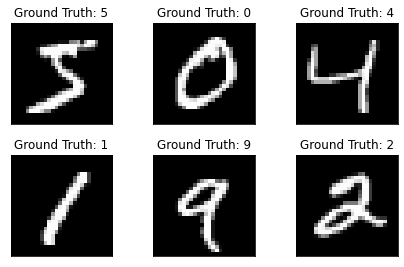

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(train_set[i][0].detach().numpy().squeeze(), cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(train_set[i][1]))
    plt.xticks([])
    plt.yticks([])

In [5]:
class MNISTConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 3, 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 2),
            nn.ReLU(),
            nn.Conv2d(64, 10, 2, 2)
        )

    def forward(self, x):
        out = self.net(x).view(x.size(0), -1)
        return out

In [6]:
target_network = MNISTConvNet()
pytorch_total_params = sum(p.numel() for p in target_network.parameters() if p.requires_grad)
pytorch_total_params

77066

### Making a custom Hypernetwork with a 2 layer Weight Generator

In [7]:
from hypernn.torch.hypernet import TorchHyperNetwork
from typing import Any, Optional

In [8]:
from typing import Any, Dict, List, Optional, Tuple, Type, Union  # noqa

class MNISTHyperNetwork(TorchHyperNetwork):
    def __init__(
        self,
        target_network: nn.Module,
        *args,
        **kwargs
    ):
        super().__init__(
                    target_network = target_network,
                    *args,
                    **kwargs
                )

    def make_weight_generator(self):
        return nn.Sequential(
            nn.Linear(self.embedding_dim, 32),
            nn.Tanh(),
            nn.Linear(32, self.weight_chunk_dim)
        )


### We can reduce the number of trainable parameters to less than 10%

In [9]:
EMBEDDING_DIM = 4
NUM_EMBEDDINGS = 512

hypernetwork = MNISTHyperNetwork.from_target(target_network, embedding_dim=EMBEDDING_DIM, num_embeddings=NUM_EMBEDDINGS)
pytorch_total_params = sum(p.numel() for p in hypernetwork.parameters() if p.requires_grad)
pytorch_total_params

7191

In [10]:
device = torch.device('cuda')
hypernetwork = hypernetwork.to(device)

In [11]:
g, _ = hypernetwork.generate_params()

#### Dataloader

In [12]:
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=32,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=32,
                shuffle=False)

#### Train MNIST classifier with supervised learning

In [13]:
import tqdm
import numpy as np

optimizer = optim.Adam(hypernetwork.parameters(), lr=0.0002)
bar = tqdm.tqdm(np.arange(1000))

for i in bar:

    train_loss = []
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        out = hypernetwork(inp=[x.to(hypernetwork.device)], has_aux=False)
        loss =  F.cross_entropy(out.to(hypernetwork.device), target.to(hypernetwork.device))
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    avg_loss = np.mean(train_loss)
    num_correct = 0
    count = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        count += x.size(0)
        with torch.no_grad():
            out = hypernetwork(inp=[x.to(hypernetwork.device)], has_aux=False)
            _, predicted = torch.max(out.detach(), -1)
        num_correct += (predicted.detach().cpu() == target.data).sum()
    accuracy = num_correct / count
    bar.set_description("Loss: {}, Test Acc: {}".format(avg_loss, accuracy))


Loss: 0.14416060206865272, Test Acc: 0.9624000191688538:   1%|      | 11/1000 [01:48<2:42:45,  9.87s/it]

KeyboardInterrupt



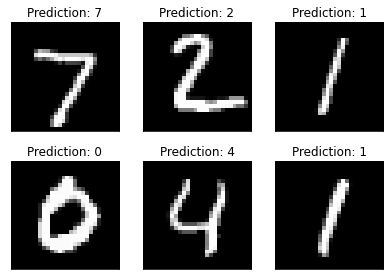

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    out = hypernetwork(inp=[test_set[i][0].to(hypernetwork.device)], has_aux=False)
    _, predicted = torch.max(out.detach(), -1)
    plt.subplot(2,3,i+1)
    plt.imshow(test_set[i][0].detach().numpy().squeeze(), cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(predicted.item()))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()